In [2]:
#Import and set magics
import numpy as np
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy as sp
from scipy import stats
from scipy import optimize
from scipy import interpolate
from scipy import linalg
import sympy as sm

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [509]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y



**The data you have access to is:**

In [510]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [511]:
#we start with creating a vector for b_0, which are our interception coefficient:
ic = np.ones(10000) 
#Then we create a matrix for our independent variables:
X = np.array([ic,x1,x2]) 
#Transposing our matrix:
XX = np.dot(X,X.transpose()) 
#Invers the above matrix:
inv = np.linalg.inv(XX) 
#computing b_hat:
b_hat = np.dot(np.dot(inv,X),y) 
#Print results of b_hat:
print(b_hat)

[0.0956821  0.29294299 0.50332771]


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

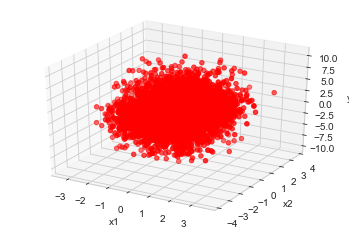

In [512]:
#3d scatterplot, first constructing predicted y:

def y_pred(x1,x2):
    prediction = b_hat(0) + b_hat(1) * x1 + b_hat(2) * x2
    return prediction
    
from mpl_toolkits.mplot3d import Axes3D
#Plotting the figure:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

x = [x1]
z = [x2]
y = [y]

ax.scatter(x, z, y, c='r', marker='o')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

plt.show()

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [513]:
#Defining the OLS 
def ols(x):
    b_0 = x[0]
    b_1 = x[1]
    b_2 = x[2]
    y_pred = b_0 + b_1*x1 + b_2*x2 #this is want we want to analyze
    v_sum = (y-y_pred)**2 #sum over variation
    result = np.sum(v_sum)
    return result
x3 = np.array([2,2,2]) #initial guess
optimize.minimize(ols,x3,method="Nelder-Mead").x

array([0.09569956, 0.29296867, 0.50329239])

**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [514]:
#Defining the Least Absolute Deviations
def Lad(x):
    b_0 = x[0]
    b_1 = x[1]
    b_2 = x[2]
    y_pred = b_0 + b_1*x1 + b_2*x2
    v_sum = (y-y_pred)
    result = np.sum(v_sum)
    return result
x3 = np.array([2,2,2]) #initial guess
optimize.minimize(ols,x3,method="Nelder-Mead").x

array([0.09569956, 0.29296867, 0.50329239])

**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [3]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
chi = 0.9
r = 0.04
Delta = 0.25

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)




**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. 

In [4]:
#Defining the functions

def v2(c,m2,d,alpha,rho,chi):
    result=((c**alpha*(d+chi*(m2-c))**(1-alpha))**(1-rho))/(1-rho)
    return -result

def v1 (m1, beta, alpha, r, d, Delta, v2_interp):
    
    
    m2_low = (1+r)*(m1-d) + 1-Delta
    v2_low = (v2_interp([m2_low],d)[0])

    m2_mid = (1+r)*(m1-d) + 1
    v2_mid = (v2_interp([m2_mid],d)[0])

    m2_hig = (1+r)*(m1-d) + 1 + Delta
    v2_hig = (v2_interp([m2_hig],d)[0])

    v2 = (1/3)*v2_low + (1/3)*v2_mid + (1/3)*v2_hig

    return beta*v2



In [6]:
#Solving period 2

def solve_period_2(alpha, rho, chi, Delta):   
    
    v2_grid = np.empty((100,100))
    c_grid = np.empty((100,100))
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):


            
              obj = lambda c: -v2(d, m2, chi, c, alpha, rho)

              x0 = m2/2

              result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=((1e-8,m2),))

              v2_grid[i,j] = -result.fun
              c_grid[i,j]  = result.x
              
              
    return  m2_vec, d_vec, v2_grid, c_grid


Plotting values of v2(m2,d),c∗(m2,d) , and x∗(m2,d)

In [7]:
#Solving
m2_vec, d_vec, v2_grid, c_grid = solve_period_2(alpha, rho, chi, Delta)

m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')


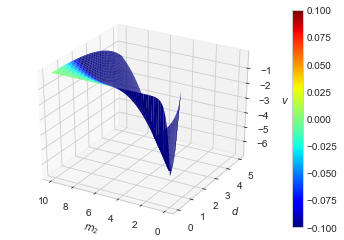

In [11]:
#PLOTTING THE FIGURES

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,v2_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs)



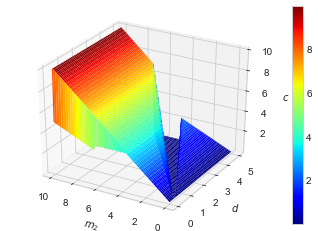

In [10]:
#PLOTTING

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_grid,cmap=cm.jet)

# d. add labels
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')

# e. invert xaxis
ax.invert_xaxis()

# f. add colorbar
fig.colorbar(cs)

In [ ]:
#Comment on the graphs above: we are aware that these are not correct, yet, we did manage to show the graphs on one computer. However, now the code does not work.. 

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. 

In [12]:
#Solving period 1
def solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp):

    m1_vec = np.linspace(1e-8,10,100)
    v1_vec = np.empty(100,100)
    d_vec  = np.linspace(1e-8,5,100)

    for i,m1 in enumerate(m1_vec):
        for j,d in enumerate(d_vec):

            obj = lambda x: -v1(x[0],m1,alpha,rho,beta,r,Delta,v2_interp)

            x0 = [m1*1/3,m1*1/3]

            bound = (m1-1e-8)
            bounds = (bound)
            ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]} 

            result = optimize.minimize(obj,x0, method='SLSQP',
                                   bounds=bounds,
                                   constraints=[ineq_con])
                                  
            
            v1_vec[i] = -result.fun
            d_vec = result.x[0]
           


        return m1_vec, v1_vec, d_vec

In [13]:
#Solve
m1_vec, v1_vec, d_vec = solve_period_1(alpha,rho,beta,r,Delta,v1,v2_interp) 
#The code above wont work, which we dont know why. We have also tried the interpolate code


NameError: name 'v2_interp' is not defined

Plotting v1(m1) and d∗(m1)


In [14]:
#PLOTTING THE FIGURES
# illustration
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1)
ax.plot(m1_vec,c_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('consumption function in period 1')

ax = fig.add_subplot(1,2,2)
ax.plot(m1_vec,v1_vec)
ax.set_xlabel('$m_1$')
ax.set_ylabel('$c_1$')
ax.set_title('value function in period 1')

NameError: name 'c_vec' is not defined

In [524]:
#Constructing interpolator
v1_interp = interpolate.RegularGridInterpolator([m1_vec], [v1_vec], 
                          bounds_error=False, fill_value=False)

NameError: name 'v1_vec' is not defined

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [525]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [532]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10_000):
    pass

    """
        
    Args:

        f (callable): function
        x0 (np.array): initial values
        jac (callable): jacobian
        alpha (list): potential step sizes
        max_iter (int): maximum number of iterations
        
    Returns:
    
        x (np.array): root
        n (int): number of iterations used
        
    """
#To minimize the function, we compute the steps below. Please notice, that some of the steps are added together, as we believe this makes more sense in regards to the code.
    #Step 1-2:
    x = x0
    it=0
    n = 1
    start_f=np.array([500,500])

    # Step 3-4: Defining jacobian for f
    while (abs(start_f[0])>epsilon or abs(start_f[1])>epsilon):
        f1_grad=1/Delta*(f(x+np.array([Delta,0]))-f(x))
        f2_grad=1/Delta*(f(x+np.array([0,Delta]))-f(x))
        start_f=np.array([f1_grad,f2_grad])
        #Step 5-8:
        f_theta=f(x-Theta*start_f)
        while (f_theta>=f(x)):
            Theta=(Theta/2)
            f_theta=f(x-Theta*start_f)
        # Step 9:
        x=(x-Theta*start_f)
        it=it+1
        if it>=max_iter:
            break
       
        #step 10: 
        n += 1
        
    return x,it
       

**Test case:**

In [533]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 578 iterations


From the above code, we have derived the minimum at (1.0000,1.0000) after 578 iterations